<a href="https://colab.research.google.com/github/kkanervo20/SaunaTonttu-Backend/blob/master/image_2_image_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [1]:
!nvidia-smi

Sat Feb 17 16:29:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install diffusers==0.8.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree.

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Image2Image pipeline.

In [4]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [5]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Download an initial image and preprocess it so we can pass it to the pipeline.

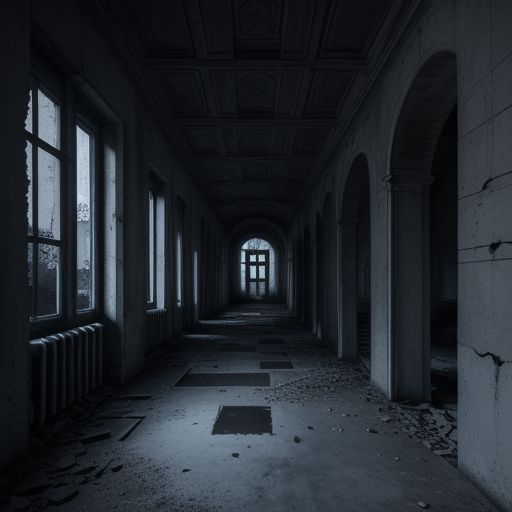

In [14]:
import requests
from io import BytesIO
from PIL import Image

file = "/content/1401FDDF663F60ED0C251673DCB68F22599202BBED69C1F67DFFE56001E61774.jpg"

#response = requests.get(url)
init_img = Image.open(file).convert("RGB")
#init_img = init_img.resize((768, 512))
init_img

Define the prompt and run the pipeline.

In [18]:
prompt = "Here be dragons" #Prompt goes here

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [21]:
generator = torch.Generator(device=device).manual_seed(1879863030)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/38 [00:00<?, ?it/s]

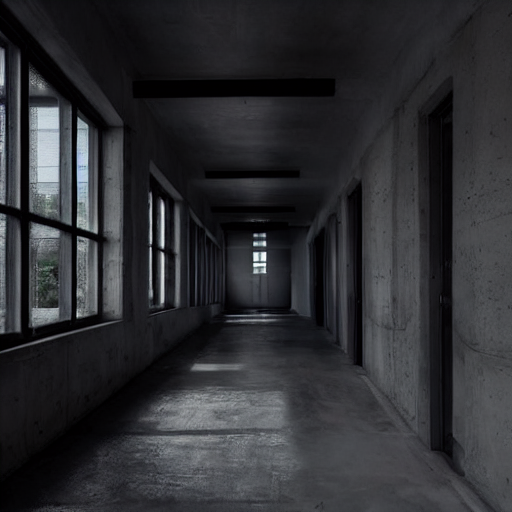

In [22]:
image

In [23]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.5, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/26 [00:00<?, ?it/s]

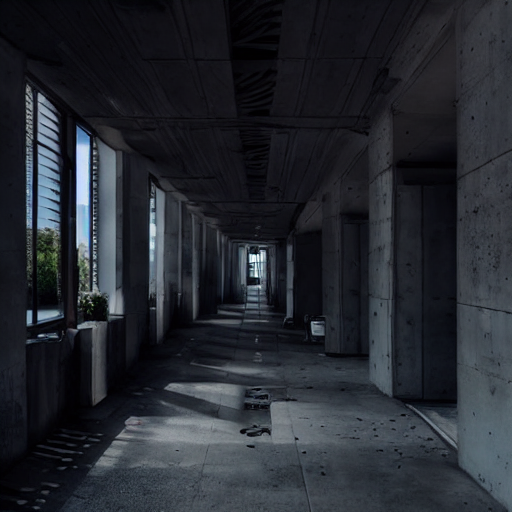

In [24]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler)

In [25]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [53]:
generator = torch.Generator(device=device).manual_seed(1879863030)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.4, guidance_scale=8, generator=generator).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

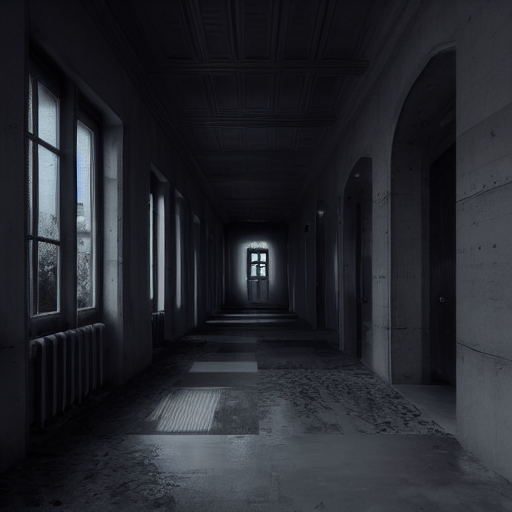

In [54]:
image